# **Tutorial 1: Paleoclimate Proxies**

**Week 1, Day 4, Paleoclimate**

**Content creators:** Sloane Garelick

**Content reviewers:** Yosmely Bermúdez, Katrina Dobson, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Brodie Pearson, Jenna Pearson, Chi Zhang, Ohad Zivan 

**Content editors:** Yosmely Bermúdez, Zahra Khodakaramimaghsoud, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

In this tutorial, you'll learn about different types of paleoclimate proxies (physical characteristics of the environment that can stand in for direct measurements), the file type they come in, and how to convert these files to more usable formats.

By the end of this tutorial you will be able to:

*   Understand some types of paleoclimate proxies and archives that exist
*   Create a global map of locations of proxy paleoclimate records in a specific data network 

# **Setup**

In [ ]:
# !pip install pandas
# !pip install pooch
# !pip install matplotlib as plt
# !pip install --no-binary shapely shapely --force # Add this to use cartopy. in this way it doesn't crush
# !pip install cartopy
# !pip install pyleoclim

In [2]:
# imports
import os
import pandas as pd
import numpy as np
import pooch # to donwload the  PAGES2K data
import matplotlib.pyplot as plt

import lipd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader

In [3]:
# @title Helper functions

# Convert the PAGES2K LiDP files into a pandas.DataFrame

# Function to convert the PAGES2K LiDP files in a pandas.DataFrame
def lipd2df(lipd_dirpath, pkl_filepath=None, col_str=[
            'paleoData_pages2kID',
            'dataSetName', 'archiveType',
            'geo_meanElev', 'geo_meanLat', 'geo_meanLon',
            'year', 'yearUnits',
            'paleoData_variableName',
            'paleoData_units',
            'paleoData_values',
            'paleoData_proxy']):
    """
    Convert a bunch of PAGES2k LiPD files to a `pandas.DataFrame` to boost data loading.

    If `pkl_filepath` isn't `None`, save the DataFrame as a pikle file.

    Parameters:
    ----------
        lipd_dirpath: str
          Path of the PAGES2k LiPD files
        pkl_filepath: str or None
          Path of the converted pickle file. Default: `None`
        col_str: list of str
          Name of the variables to extract from the LiPD files

    Returns:
    -------
        df: `pandas.DataFrame`
          Converted Pandas DataFrame
    """

    # Save the current working directory for later use, as the LiPD utility will change it in the background
    work_dir = os.getcwd()
    # LiPD utility requries the absolute path
    lipd_dirpath = os.path.abspath(lipd_dirpath)
    # Load LiPD files
    lipds = lipd.readLipd(lipd_dirpath)
    # Extract timeseries from the list of LiDP objects
    ts_list = lipd.extractTs(lipds)
    # Recover the working directory
    os.chdir(work_dir)
    # Create an empty pandas.DataFrame with the number of rows to be the number of the timeseries (PAGES2k records),
    # and the columns to be the variables we'd like to extract
    df_tmp = pd.DataFrame(index=range(len(ts_list)), columns=col_str)
    # Loop over the timeseries and pick those for global temperature analysis
    i = 0
    for ts in ts_list:
        if 'paleoData_useInGlobalTemperatureAnalysis' in ts.keys() and \
            ts['paleoData_useInGlobalTemperatureAnalysis'] == 'TRUE':
            for name in col_str:
                try:
                    df_tmp.loc[i, name] = ts[name]
                except:
                    df_tmp.loc[i, name] = np.nan
            i += 1
    # Drop the rows with all NaNs (those not for global temperature analysis)
    df = df_tmp.dropna(how='all')
    # Save the dataframe to a pickle file for later use
    if pkl_filepath:
        save_path = os.path.abspath(pkl_filepath)
        print(f'Saving pickle file at: {save_path}')
        df.to_pickle(save_path)
    return df

In [4]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

# **Section 1: Introduction to PAGES2k**

As we've now seen from introductory video, there are various types of [paleoclimate archives and proxies](http://wiki.linked.earth/Climate_Proxy) that can be used to reconstruct past changes in Earth's climate. For example:

- **Sediment Cores**: Sediments deposited in layers within lakes and oceans serve as a record of climate variations over time. Various proxies for past climate are preserved in sediment cores including, pollen, microfossils, charcoal, microscopic organisms, organic molecules, etc.
- **Ice Cores**: Similarly to sediment cores, ice cores capture past climate changes in layers of ice accumulated over time. Common proxies for reconstructing past climate in ice cores include water isotopes, greenhouse gas concentrations of air bubbles in the ice, and dust.
- **Corals**: Corals form annual growth bands within their carbonate skeletons, recording temperature changes over time. Scientists analyze the chemical composition of each layer to reconstruct temperature and salinity. Corals typically preserve relatively short paleoclimate records, but they provide very high-resolution reconstructions (monthly and seasonal) and are therefore valuable for understanding past changes in short-term phenomena.
- **Speleothems**: These are cave formations that result from the deposition of minerals from groundwater. As the water flows into the cave, thin layers of minerals (e.g., calcium carbonate), are deposited. The thickness and chemical composition of speleothem layers can be used to reconstruct climate changes in the past.
- **Tree Rings**: Each year, trees add a new layer of growth, known as a tree ring. These rings record changes in temperature and precipitation. Proxy measurements of tree rings include thickness and isotopes, which reflect annual variability in moisture and temperature.

There are many existing paleoclimate reconstructions spanning a variety of timescales and from global locations. Given the temporal and spatial vastness of existing paleoclimate records, it can be challenging to know what paleoclimate data already exists and where to find it. One useful solution is compiling all existing paleoclimate records for a single climate variable (temperature, greenhouse gas concentration, precipitation, etc.) and over a specific time period (Holocene to present, the past 800,000 years, etc.). 

One example of this is the **PAGES2k network**, which is a community-sourced database of temperature-sensitive proxy records. The database consists of 692 records from 648 locations, that are from a variety of archives (e.g., trees, ice, sediment, corals, speleothems, etc.) and span the Common Era (1 CE to present, i.e., the past ~2,000 years). You can read more about the PAGES2k network, in [PAGES 2k Consortium (2017)](https://www.nature.com/articles/sdata201788).

In this tutorial, we will explore the types of proxy records in the PAGES2k network and create a map of proxy record locations.

# **Section 2: Get PAGES2k LiPD Files**

The PAGES2k network is stored in a specific file format known as [Linked Paleo Data format (LiPD)](http://wiki.linked.earth/Linked_Paleo_Data). LiPD files contain time series information in addition to supporting metadata (e.g., root metadata, location). Pyleoclim (and its dependency package LiPD) leverages this additional information using LiPD-specific functionality.

Data stored in the .lpd format can be loaded directly as an Lipd object. If the data_path points to one LiPD file, `lipd.readLipd.()` will load the specific record, while if data_path points to a folder of lipd files, `lipd.readLipd.()` will load the full set of records. This function to read in the data is imbedded in the helper function above used to read the data in and convert it to a more usable format.

The first thing we need to do it to download the data.

In [5]:
# Set the name to save the PAGES2K data
fname = "pages2k_data"

# Download the data
lipd_file_path = pooch.retrieve(
    url="https://ndownloader.figshare.com/files/8119937",
    known_hash=None,
    path="./",
    fname=fname,
    processor=pooch.Unzip()
)

Now we can use our helpfer function `lipd_2df()` to convert the LiPD files to a [Pandas dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

NOTE: when you run some of the next code cell to convert the Lipd files to a DataFrame, you will get some error messages. This is fine and the code will still accomplish what it needs to do. The code will also take a few minutes to run, so if it's taking longer than you'd expect, that's alright!

In [6]:
# convert all the lipd files into a DataFrame
fname = "pages2k_data"

pages2k_data = lipd2df(lipd_dirpath=os.path.join(".", f"{fname}.unzip", "LiPD_Files"))

Disclaimer: LiPD files may be updated and modified to adhere to standards

Found: 657 LiPD file(s)
reading: Ant-WDC05A.Steig.2013.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Arc-Arjeplog.Bjorklund.2014.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: NAm-co517.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dic

reading: NAm-cana432.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictiona

Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-BIARLS.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Eur-NorthIceland.Ran.2011.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asi

reading: Ocean2kHR-PacificLinsley2006Rarotongad18O2R.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-BUKCDD.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-PTCYUN.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-UKHEWW.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file

reading: NAm-ak070.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary

reading: Arc-Cook2009.lpd
1.77 MB :That's a big file! This may take a while to load...
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: NAm-ak114.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: diction

reading: NAm-cana421.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictiona

reading: O2kLR-NWPacific.Harada.2004.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-Aktru2.Panyushkina.2005.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: NAm-ca529.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary 

reading: Arc-NGTB16.Fischer.1998.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Ocean2kHR-IndianMafiaDamassa2006.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-Ugla.Panyushkina.2005.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD 

reading: Asia-BAG2JU.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-HRPCSM.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: NAm-ak102.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Err

reading: Ocean2kHR-AtlanticMontegoBayHaaseSchramm2003.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Ocean2kHR-PacificMooreaBoiseau2003.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-ZSMDLS.lpd
Error: Unable to update file 

reading: Eur-LakeSilvapla.Trachsel.2010.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-YKCOM.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Ant-VLG.Bertler.2011.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Arc-Tjeggelvas.Bjorkelund.2013.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable 

reading: Asia-DLH4.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-Middlereache.Zhang.1980.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Ocean2kHR-IndianBaliCharles2003.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Ocean2kHR-IndianIfatyTulearZinke2014if1.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iterati

Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-ISBCDD.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-KunashirIsla.Demezhko.2009.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error:

reading: O2kLR-AlboranSea-TTR17-1436B.Nieto-Moreno.2012.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Eur-SouthIceland.Moffa-Sanchez2014.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Ocean2kHR-IndianMentawaiAbram2008.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: NAm-GreenLake.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys cha

reading: NAm-az555.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary

Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: NAm-ca603.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary

Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-WL3.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Aus-Duckhole.Saunders.2013.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable 

Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-XCHSIC.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-EastChinareg.Wang.1998.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: N

reading: Asia-WL1.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Ocean2kHR-PacificLiangTudhope2001.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: NAm-RubyL.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-RACHAS.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: 

reading: NAm-wy022.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary

reading: Asia-MOR1JU.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-BIGELS.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: O2kLR-JacafFjord.Sepulveda.2009.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys change

reading: Ocean2kHR-PacificClippertonClipp4bWu2014.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-QAMDJT.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: O2kLR-PigmyBasin.Richey.2009.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1

reading: NAm-OCNM.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-UKHLWD.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Ant-DSS.Moy.2012.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-KARPCS.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys

reading: Ocean2kHR-AtlanticBermudaKuhnert2002.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Ocean2kHR-PacificLinsley2006Rarotongad18O99.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-SMASLY.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file

reading: NAm-CTR.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary k

Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during it

reading: Eur-CentralEu.Buntgen.2011.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: O2kLR-FiskBasin.Richey.2009.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during itera

reading: Ocean2kHR-IndianWAGrowthAbrolhosCooper2012.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-NYINJT.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-HOCKJT.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary 

reading: O2kLR-EmeraldBasin.Keigwin.2003.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-LAMIAB.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-YAKHTD.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys change

reading: O2kLR-SantaBarbara.Zhao.2000.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: NAm-mt126.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unab

reading: Asia-Kur3.Magda.2011.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-GHURCH.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Arc-McCarrol.Forfjordalen.2013.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Ant-TalosDome.Stenni.2002.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to u

reading: NAm-cana238.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictiona

extracting: Ant-USITASE20001.Steig.2013
extracting: Ocean2kHR-IndianMayotteZinke20082009
extracting: NAm-cana446
extracting: Asia-CILAUP
extracting: Asia-DLH5
extracting: Asia-MCCHFH
extracting: O2kLR-EasternTropicalNorthAtlantic.Kuhnert.2011
extracting: SAm-QuelccayaIce.Thompson.2013
extracting: O2kLRMakassarStrait-MD98-2160.Newton.2011
extracting: Ant-MES.Bertler.2012
extracting: Arc-GRIP.Vinther.2010
extracting: Asia-ISBCDD
extracting: Asia-KunashirIsla.Demezhko.2009
extracting: Asia-SAT3JU
extracting: Ocean2kHR-IndianAbrolhosZinke2014HAB10A
extracting: Asia-TSO
extracting: Asia-BDFLON
extracting: O2kLR-Minorca.Moreno.2012
extracting: Arc-NGRIP1.Vinther.2006
extracting: Asia-11YCT
extracting: Asia-BULGLS
extracting: Asia-PHUMTD
extracting: O2kLR-EmeraldBasin.Sachs.2007
extracting: Asia-22DLT
extracting: Asia-HEBQIN
extracting: NAm-cana091
extracting: NAm-mexi043
extracting: Arc-Schneider.2015.PolarUrals
extracting: Asia-DULAJP
extracting: Asia-HunanJiangsu.Zhang.1980
extracting: Oce

extracting: Asia-TANSIC
extracting: O2kLR-RAPiD-12-1K.Thornalley.2009
extracting: Ocean2kHR-PacificClippertonClippf1bWu2014
extracting: Asia-XIANGC
extracting: Asia-MHGSTG
extracting: Asia-MOR4JU
extracting: O2kLR-CapeHatteras.Cléroux.2012
extracting: SAm-CAN11.Neukom.2011
extracting: Ant-Vostok.Ekaykin.2014
extracting: NAm-Hell_Kt
extracting: NAm-ak046
extracting: Asia-KMD
extracting: Asia-BAWSIC
extracting: Ocean2kHR-PacificCoralSeaCalvo2007
extracting: Asia-HSW
extracting: NAm-mt120
extracting: NAm-mt108
extracting: NAm-ak132
extracting: Asia-Guangdongand.Zhang.1980
extracting: Ant-DomeC.Stenni.2001
extracting: Ocean2kHR-AtlanticBermudaDraschba2000a
extracting: Eur-Tat12
extracting: Ocean2kHR-AtlanticBermudaGoodkin2006
extracting: Asia-Kur2.Magda.2011
extracting: Ant-WDC05ABoreholeTreconstruction
extracting: Asia-QUMAJP
extracting: NAm-ca530
extracting: Asia-SODAPS
extracting: Arc-Luoto2009
extracting: Africa-Malawi.Powers.2011
extracting: NAm-cana029
extracting: Arc-Crete.Vinther.2

The PAGES2k data is now stored as a dataframe and we can view the data to understand different attributes it contains.

In [19]:
# print the top few rows of the PAGES2K data
pages2k_data.head()

,paleoData_pages2kID,dataSetName,archiveType,geo_meanElev,geo_meanLat,geo_meanLon,year,yearUnits,paleoData_variableName,paleoData_units,paleoData_values,paleoData_proxy
0,Ant_006,Ant-WDC05A.Steig.2013,glacier ice,1806.0,-79.46,-112.09,"[2005.0, 2004.0, 2003.0, 2002.0, 2001.0, 2000....",AD,d18O,permil,"[-33.32873325, -35.6732, -33.1574, -34.2854, -...",d18O
1,Arc_065,Arc-Arjeplog.Bjorklund.2014,tree,800.0,66.3,18.2,"[1200.0, 1201.0, 1202.0, 1203.0, 1204.0, 1205....",AD,density,NA,"[-0.829089212152348, -0.733882889924006, -0.89...",delta Density
2,NAm_164,NAm-co517,tree,3320.0,40.1,-105.6,"[1610.0, 1611.0, 1612.0, 1613.0, 1614.0, 1615....",AD,MXD,NA,"[1.051, 0.992, 0.992, 1.071, 1.051, 1.011, 1.0...",MXD
3,Ocn_023,O2kLR-GreatBahamaBank.Lund.2006,marine sediment,-531.0,24.58,-79.26,"[1950.0, 1927.48, 1904.96, 1882.44, 1859.92, 1...",AD,temperature,degC,"[28.66, 28.28, 28.36, 28.38, 28.51, 28.32, 28....",foram Mg/Ca
4,Asi_060,Asia-HBHXJP,tree,2100.0,34.78,100.82,"[1500.0, 1501.0, 1502.0, 1503.0, 1504.0, 1505....",AD,trsgi,NA,"[0.73, 0.786, 0.818, 0.837, 0.823, 0.995, 1.15...",TRW


# **Section 3: Plotting a Map of Proxy Reconstruction Locations**

Now that we have converted the data into a Pandas dataframe, we can plot the PAGES2k network on a map to understand the spatial distribution of the temperature records and the types of proxies that were measured.

Before generating the plot, we have to define the colours and the marker types that we want to use in the plot. We also need to set a list with the different `archive_type` names that appear in the data frame.

/Users/jennapearson/anaconda3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1700: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  result = super().scatter(*args, **kwargs)
/Users/jennapearson/anaconda3/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


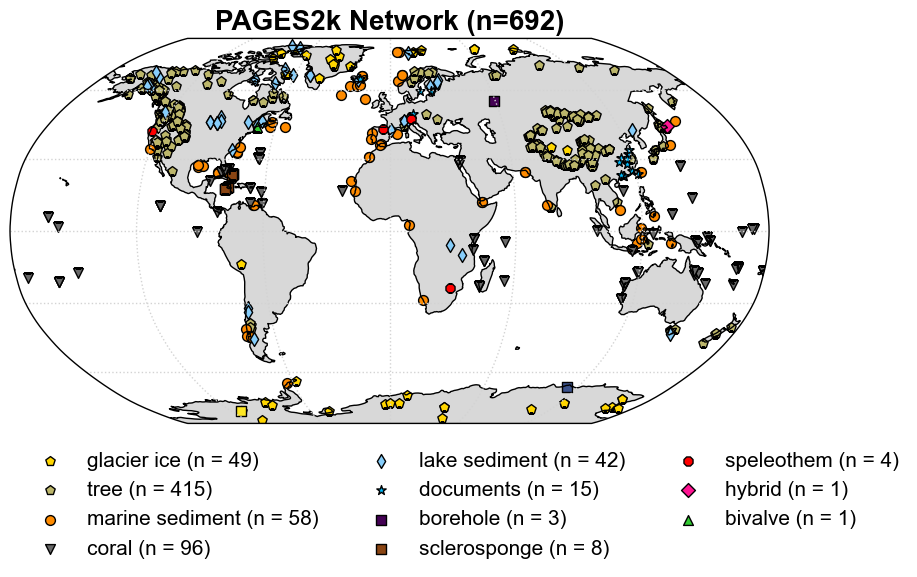

In [21]:
# list of markers and colors for the different archive_type
markers = ['p', 'p', 'o', 'v', 'd', '*', 's', 's', '8', 'D', '^']
colors = [
    np.array([ 1., 0.83984375, 0.]),
    np.array([ 0.73828125, 0.71484375, 0.41796875]),
    np.array([ 1., 0.546875, 0.]),
    np.array([ 0.41015625, 0.41015625, 0.41015625]),
    np.array([ 0.52734375, 0.8046875 , 0.97916667]),
    np.array([ 0., 0.74609375, 1.]),
    np.array([ 0.25390625, 0.41015625, 0.87890625]),
    np.array([ 0.54296875, 0.26953125, 0.07421875]),
    np.array([ 1, 0, 0]),
    np.array([ 1., 0.078125  , 0.57421875]),
    np.array([ 0.1953125, 0.80078125, 0.1953125])
]

# create the plot

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# add plot title
plt.title(f'PAGES2k Network (n={len(pages2k_data)})', fontsize=20, fontweight='bold')

# set the base map
# ----------------
ax.set_global()

# add coast lines
ax.coastlines()

# add land fratures using gray color
ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)

# add gridlines for latitude and longitude
ax.gridlines(edgecolor='gray', linestyle=':')


# plot the different archive types
# -------------------------------

# extract the name of the different archive types
archive_types = pages2k_data.archiveType.unique()

# plot the archive_type using a forloop
for i, type_i in enumerate(archive_types):
    df = pages2k_data[pages2k_data['archiveType']==type_i]
    # count the number of appearances of the same archive_type
    count = df['archiveType'].count()
    # generate the plot
    ax.scatter(
        df['geo_meanLon'],
        df['geo_meanLat'],
        marker=markers[i],
        c=colors[i],
        edgecolor='k',
        s=50,
        transform=ccrs.Geodetic(),
        label=f'{type_i} (n = {count})',
    )
# add legend to the plot
ax.legend(
    scatterpoints=1,
    bbox_to_anchor=(0, -0.4),
    loc='lower left',
    ncol=3,
    fontsize=15,
)

plt.show()

## Questions 3

You have just plotted the global distribution and temperature proxy type of the 692 records in the PAGES2k network!

1. Which temperature proxy is the most and least abundant in this database?
2. In what region do you observe the most and least temperature records? Why might this be the case?


In [1]:
# to_remove explanation 

"""
1. The most abundant temperature proxy is tree ring and the least one is hybrid (tree/borehole) or bivalve. Tree rings form the basis for more than half of these records, and this can be attributed to their annual resolution, exact dating, and broad geographical distribution, most notably in the Northern Hemisphere's mid-latitudes.
2. The spatial distribution of proxy archives reveals an overwhelming distribution of records situated on land within the Northern Hemisphere. The least amount of records seem to come from Antarctica, as well as central South America and Africa. These areas are often remote and hard to get to, whether an ice-sheet, a rainforest, or a desert. This makes it difficult to reach these locations, and their cliamte biome may not be suitable for many proxy types.
""";

# **Summary**

In this tutorial, you explored the PAGES2K network, which offers an extensive collection of proxy temperature reconstructions spanning the last 2,000 years. You surveyed various types of paleoclimate proxies and archives available, in addition to crafting a global map pinpointing the locations of the PAGES2k proxy records. As you advance throughout this module, you will extract and meticulously analyze the temperature timelines embedded within reconstructions such as those shown here.

# **Resources**

Code for this tutorial is based on existing notebooks from LinkedEarth that [convert LiPD files to a Pandas dataframe](https://github.com/LinkedEarth/notebooks/blob/master/PAGES2k/01.lipd2df.ipynb) and [create a map of the PAGES2k network](https:///github.com/LinkedEarth/notebooks/blob/master/PAGES2k/02.plot_map.ipynb).

The following data is used in this tutorial:


*   PAGES2k Consortium. A global multiproxy database for temperature reconstructions of the Common Era. Sci Data 4, 170088 (2017). https://doi.org/10.1038/sdata.2017.88